In [2]:
import pandas as pd
import numpy as np

f_train = pd.read_csv("/hdd1/zhaoqi/max_data/2_3_max_train_data", index_col=0, sep=",")
f_val = pd.read_csv("/hdd1/zhaoqi/max_data/2_3_max_val_data", index_col=0, sep=",")
f_test = pd.read_csv("/hdd1/zhaoqi/max_data/2_3_max_test_data", index_col=0, sep=",")

In [3]:
import os

import pymysql
from warnings import filterwarnings

_connection = None

def get_connection(db_config):
    """
    get db connection
    :return:
    """
    global _connection
    if _connection is None:
        _connection = pymysql.connect(host=db_config['host'], user=db_config['username'],
                                      password=db_config['password'],
                                      db=db_config['db'], charset="utf8")
        filterwarnings('ignore', category=pymysql.Warning)

    return _connection


def close():
    """
    close DB connection
    :return:
    """
    global _connection
    if _connection is not None:
        _connection.close()
    _connection = None
    
db = {
    'host': '172.26.187.242',
    'username': 'malware_r',
    'password': 'GEg22v2O7jbfWhb3',
    'db': 'malware'
}

import time

# the base function which can query sql and return dict data
def get_specific_data(table_suffix, sql=None):
    start_time = time.time()
    
    global _connection
    if _connection is None:
        raise Exception("please init db connect first")

    cursor = _connection.cursor()
    cursor.execute("SET NAMES utf8mb4")

    ret = []
        
    cursor.execute(sql)

    field_names = [i[0] for i in cursor.description]

    for row in cursor:
        temp = {}
        for key in range(len(row)):
            temp[field_names[key]] = row[key]
        ret.append(temp)
     
    cursor.close()
    # _connection.close()
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return ret

close()
res1 = []
get_connection(db)
table_suffix = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
# Iterate all partitions of databases
for suffix in table_suffix:
    sql = """ 
select
  c.mw_file_hash,
  d.mw_em_f
from mw_index_2017_%s c
  inner join mw_index_2017_feature_%s d on c.mw_file_hash = d.mw_file_hash
where c.mw_num_engines <> -1 and (c.mw_num_engines > 6 or c.mw_num_engines = 0) and
      c.mw_file_prefix in ('201702', '201703')
    """ % (suffix, suffix)
    res1.extend(get_specific_data(suffix, sql))
close()
print(len(res1))

index_data = pd.DataFrame(res1)

--- 9.252520322799683 seconds ---
--- 10.219123363494873 seconds ---
--- 10.814337968826294 seconds ---
--- 10.658259391784668 seconds ---
--- 10.400429248809814 seconds ---
--- 10.631350755691528 seconds ---
--- 11.952308416366577 seconds ---
--- 8.888760328292847 seconds ---
--- 9.028561353683472 seconds ---
--- 9.067997694015503 seconds ---
--- 10.363254070281982 seconds ---
--- 9.908128023147583 seconds ---
--- 10.436088800430298 seconds ---
--- 8.727606296539307 seconds ---
--- 6.8555357456207275 seconds ---
--- 6.51743483543396 seconds ---
291096


In [40]:
train_data = f_train.groupby(['mw_file_hash'], sort=False).max()
val_data = f_val.groupby(['mw_file_hash'], sort=False).max()
test_data = f_test.groupby(['mw_file_hash'], sort=False).max()

In [41]:
train_data = f_train.merge(index_data, how='left', left_on='mw_file_hash', right_on='mw_file_hash')
val_data = f_val.merge(index_data, how='left', left_on='mw_file_hash', right_on='mw_file_hash')
test_data = f_test.merge(index_data, how='left', left_on='mw_file_hash', right_on='mw_file_hash')

In [42]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,mw_file_hash,label,mw_em_f
0,-0.080398,0.447328,0.198418,-0.936106,1.024898,0.548980,-0.771374,-0.283236,-0.242323,0.787232,...,0.277092,-0.219789,-1.925474,-0.776626,-0.275708,-0.015300,-0.121640,24D288DB946B9B9158B7DDEF1D6540174B5D9EA1F09FDC...,0,0.5940913558006287;0.006977689918130636;0.0037...
1,0.195338,0.529729,0.059648,-2.133648,2.471335,-0.039530,-2.258612,-0.015451,-0.559171,1.707390,...,-0.089693,-0.560589,-2.219065,-1.497957,0.098181,-0.647798,-0.548343,1AFDDB9CB0A6035D8AC8288CA9804833F5146553431440...,0,0.14833371341228485;0.01657847315073013;0.0065...
2,-0.178841,0.141042,-0.232072,0.366904,-0.703295,-0.309368,0.631538,-0.030445,0.520919,-0.544116,...,-0.209858,-0.333553,0.627041,0.588465,-0.009490,0.433101,-0.144596,E8F233EF47B338840F998A8262ED8E691CF243A647E9D7...,1,0.13389156758785248;0.020534789189696312;0.003...
3,-0.249344,0.192570,-0.380944,1.558958,-1.462468,-0.428363,1.193027,-0.198265,0.531232,-1.073846,...,-0.021843,-0.055388,1.345348,1.087707,-0.243722,0.214279,-0.249094,1A688DD792A0CF46085B6B19C67B33DC67F0B252E84289...,1,0.30832210183143616;0.004371983930468559;0.003...
4,0.269126,0.734526,0.244806,-1.935600,2.235407,0.171627,-1.728072,0.498041,-0.581737,1.825187,...,0.624980,0.175004,-3.100303,-1.951052,-0.058726,-0.665974,0.102908,147C93DDFCF6C6574CA7D20F5AE40BBD2B1AAFFCF36D0E...,0,0.38241660594940186;0.0039326436817646035;0.00...


In [45]:
def get_ember_feature(data):
    ember_f = np.zeros((len(data.mw_em_f), 2351), dtype=float)
    for index, item in data.iterrows():
        ember_f[index, :] = item['mw_em_f'].split(';')
    return ember_f

e_train = get_ember_feature(train_data)
e_val = get_ember_feature(val_data)
e_test = get_ember_feature(test_data)

In [50]:
y_train = train_data.label
y_val = val_data.label
y_test = test_data.label

m_train = train_data.drop(['mw_file_hash', 'mw_em_f', 'label'], axis=1)
m_val = val_data.drop(['mw_file_hash', 'mw_em_f', 'label'], axis=1)
m_test = test_data.drop(['mw_file_hash', 'mw_em_f', 'label'], axis=1)

In [9]:
import pandas as pd
import re
import hashlib
import numpy as np
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix

def get_model(x_train, y_train, x_val, y_val):
    params = {'application': 'binary'}
    lgbm_dataset = lgb.Dataset(x_train, y_train.ravel())
    valid_sets = lgb.Dataset(x_val, y_val.ravel())

    model = lgb.train(params, lgbm_dataset, valid_sets=valid_sets, early_stopping_rounds=10)
    y_pred = model.predict(x_val)
    
    loss = log_loss(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    acc = accuracy_score(y_val, (y_pred > 0.5).astype(int))
#     model.save_model(file_path + "-%04d-%.5f-%.5f.h5" % (model.best_iteration, loss, acc),
#                      num_iteration=model.best_iteration)
    print("val loss : %.5f" % loss)
    print("auc score : %.5f" % auc)
    print("accuracy score : %.5f" % acc)
        
    return model


def estimate_model(y_pred, test_y):
    
    loss = log_loss(test_y, y_pred)
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y, (y_pred > 0.5).astype(int))
    print("loss : %.5f" % loss)
    print("auc score : %.5f" % auc)
    print("accuracy score : %.5f" % acc)

    fp_np_index = np.where(test_y == 0)
    fp_np = y_pred[fp_np_index].shape[0]
    thre_index = int(np.ceil(fp_np - fp_np * 0.001))

    sorted_pred_prob = np.sort(y_pred[fp_np_index], axis=0)
    thre = sorted_pred_prob[thre_index]
    if thre == 1:
        thre = max(sorted_pred_prob[np.where(sorted_pred_prob != 1)])

    y_pred_prob = np.vstack((y_pred.transpose(), (1 - y_pred).transpose())).transpose()
    y_pred_prob[:, 1] = thre
    y_pred_label = np.argmin(y_pred_prob, axis=-1)

    tn, fp, fn, tp = confusion_matrix(test_y, y_pred_label).ravel()
    fp_rate = fp / (fp + tn)
    recall_rate = tp / (tp + fn)

    print("thre: %.10f"%  thre)
    print("fp:  %.10f"%  fp_rate)
    print("recall:  %.10f"%  recall_rate)
    
    return auc, loss, recall_rate

In [18]:
model_m = get_model(e_train, y_train, e_val, y_val )

[1]	valid_0's binary_logloss: 0.565341
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.506063
[3]	valid_0's binary_logloss: 0.457113
[4]	valid_0's binary_logloss: 0.416244
[5]	valid_0's binary_logloss: 0.381793
[6]	valid_0's binary_logloss: 0.352023
[7]	valid_0's binary_logloss: 0.32592
[8]	valid_0's binary_logloss: 0.303363
[9]	valid_0's binary_logloss: 0.283483
[10]	valid_0's binary_logloss: 0.266005
[11]	valid_0's binary_logloss: 0.250582
[12]	valid_0's binary_logloss: 0.236514
[13]	valid_0's binary_logloss: 0.224388
[14]	valid_0's binary_logloss: 0.213548
[15]	valid_0's binary_logloss: 0.203784
[16]	valid_0's binary_logloss: 0.195428
[17]	valid_0's binary_logloss: 0.187766
[18]	valid_0's binary_logloss: 0.181322
[19]	valid_0's binary_logloss: 0.174967
[20]	valid_0's binary_logloss: 0.169334
[21]	valid_0's binary_logloss: 0.164494
[22]	valid_0's binary_logloss: 0.159787
[23]	valid_0's binary_logloss: 0.155711
[24]	valid_0's binary_loglos

In [19]:
y_p = model_m.predict(e_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

loss : 0.16908
auc score : 0.98785
accuracy score : 0.94572
thre: 0.8986356149
fp:  0.0009869459
recall:  0.6209252435


(0.9878461097146237, 0.16907896548368886, 0.6209252434949657)

In [47]:
model_m = get_model(e_train[:,688:943], y_train, e_val[:,688:943], y_val )

[1]	valid_0's binary_logloss: 0.567717
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.509888
[3]	valid_0's binary_logloss: 0.462738
[4]	valid_0's binary_logloss: 0.423385
[5]	valid_0's binary_logloss: 0.390365
[6]	valid_0's binary_logloss: 0.362038
[7]	valid_0's binary_logloss: 0.337794
[8]	valid_0's binary_logloss: 0.316675
[9]	valid_0's binary_logloss: 0.298267
[10]	valid_0's binary_logloss: 0.281933
[11]	valid_0's binary_logloss: 0.267691
[12]	valid_0's binary_logloss: 0.255445
[13]	valid_0's binary_logloss: 0.244256
[14]	valid_0's binary_logloss: 0.234394
[15]	valid_0's binary_logloss: 0.225861
[16]	valid_0's binary_logloss: 0.217723
[17]	valid_0's binary_logloss: 0.21063
[18]	valid_0's binary_logloss: 0.20417
[19]	valid_0's binary_logloss: 0.198541
[20]	valid_0's binary_logloss: 0.193497
[21]	valid_0's binary_logloss: 0.188783
[22]	valid_0's binary_logloss: 0.184451
[23]	valid_0's binary_logloss: 0.180642
[24]	valid_0's binary_logloss

In [48]:
y_p = model_m.predict(e_test[:,688:943])
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

loss : 0.17256
auc score : 0.98997
accuracy score : 0.94432
thre: 0.8725468279
fp:  0.0009869459
recall:  0.6291476368


(0.989966741897436, 0.17255557785065956, 0.6291476368094124)

In [52]:
model_m = get_model(m_train, y_train, m_val, y_val )

[1]	valid_0's binary_logloss: 0.563584
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.502839
[3]	valid_0's binary_logloss: 0.453647
[4]	valid_0's binary_logloss: 0.412928
[5]	valid_0's binary_logloss: 0.378799
[6]	valid_0's binary_logloss: 0.349981
[7]	valid_0's binary_logloss: 0.325435
[8]	valid_0's binary_logloss: 0.304508
[9]	valid_0's binary_logloss: 0.286389
[10]	valid_0's binary_logloss: 0.270955
[11]	valid_0's binary_logloss: 0.257618
[12]	valid_0's binary_logloss: 0.246069
[13]	valid_0's binary_logloss: 0.236001
[14]	valid_0's binary_logloss: 0.22729
[15]	valid_0's binary_logloss: 0.219804
[16]	valid_0's binary_logloss: 0.213447
[17]	valid_0's binary_logloss: 0.20784
[18]	valid_0's binary_logloss: 0.203037
[19]	valid_0's binary_logloss: 0.198838
[20]	valid_0's binary_logloss: 0.195321
[21]	valid_0's binary_logloss: 0.192321
[22]	valid_0's binary_logloss: 0.189864
[23]	valid_0's binary_logloss: 0.187617
[24]	valid_0's binary_logloss

In [54]:
y_p = model_m.predict(m_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

loss : 0.25045
auc score : 0.97269
accuracy score : 0.92630
thre: 0.9477830352
fp:  0.0009869459
recall:  0.3179898491


(0.9726884903490269, 0.2504496441769919, 0.3179898490817082)

Plot feature importances...


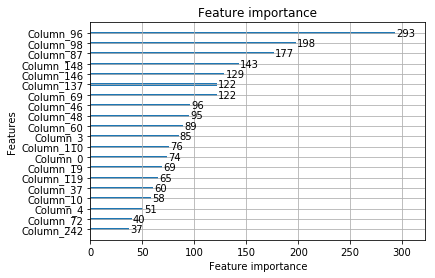

In [39]:
import matplotlib.pyplot as plt

print('Plot feature importances...')
ax = lgb.plot_importance(model_m, max_num_features=20)
plt.show()

In [32]:
idx = 0
for num in e_test[0]:
    print(idx, num)
    idx += 1

0 0.07882308959960938
1 0.011871337890625
2 0.005954742431640625
3 0.003475189208984375
4 0.006183624267578125
5 0.002285003662109375
6 0.002593994140625
7 0.003597259521484375
8 0.007038116455078125
9 0.00252532958984375
10 0.008083343505859375
11 0.003566741943359375
12 0.00469970703125
13 0.00244903564453125
14 0.00229644775390625
15 0.0027313232421875
16 0.00421905517578125
17 0.003452301025390625
18 0.00397491455078125
19 0.004177093505859375
20 0.004467010498046875
21 0.00287628173828125
22 0.002246856689453125
23 0.0033416748046875
24 0.003086090087890625
25 0.002254486083984375
26 0.002788543701171875
27 0.00276947021484375
28 0.002826690673828125
29 0.002960205078125
30 0.00449371337890625
31 0.00240325927734375
32 0.002971649169921875
33 0.002166748046875
34 0.003147125244140625
35 0.003063201904296875
36 0.006305694580078125
37 0.003856658935546875
38 0.00209808349609375
39 0.002864837646484375
40 0.0026397705078125
41 0.00202178955078125
42 0.002704620361328125
43 0.0031547

1181 0.0
1182 0.0
1183 0.0
1184 0.0
1185 0.0
1186 0.0
1187 0.0
1188 0.0
1189 0.0
1190 0.0
1191 0.0
1192 0.0
1193 0.0
1194 0.0
1195 0.0
1196 0.0
1197 0.0
1198 0.0
1199 0.0
1200 0.0
1201 0.0
1202 0.0
1203 0.0
1204 0.0
1205 0.0
1206 0.0
1207 0.0
1208 0.0
1209 0.0
1210 0.0
1211 0.0
1212 0.0
1213 0.0
1214 0.0
1215 0.0
1216 0.0
1217 0.0
1218 0.0
1219 0.0
1220 0.0
1221 0.0
1222 0.0
1223 0.0
1224 0.0
1225 0.0
1226 0.0
1227 0.0
1228 0.0
1229 0.0
1230 0.0
1231 0.0
1232 0.0
1233 0.0
1234 0.0
1235 0.0
1236 0.0
1237 0.0
1238 0.0
1239 0.0
1240 0.0
1241 0.0
1242 0.0
1243 0.0
1244 0.0
1245 0.0
1246 0.0
1247 0.0
1248 0.0
1249 0.0
1250 0.0
1251 0.0
1252 0.0
1253 0.0
1254 0.0
1255 0.0
1256 0.0
1257 0.0
1258 0.0
1259 0.0
1260 0.0
1261 0.0
1262 0.0
1263 0.0
1264 0.0
1265 0.0
1266 0.0
1267 0.0
1268 0.0
1269 0.0
1270 0.0
1271 0.0
1272 0.0
1273 0.0
1274 0.0
1275 0.0
1276 0.0
1277 0.0
1278 0.0
1279 0.0
1280 0.0
1281 0.0
1282 0.0
1283 0.0
1284 0.0
1285 0.0
1286 0.0
1287 0.0
1288 0.0
1289 0.0
1290 0.0
1291 0.0
1

In [34]:
e_test[0][688:943]

array([ 5.00000000e+00,  1.00000000e+00,  0.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.17440000e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.28000000e+05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.72800000e+03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

import xgboost as xgb

model1 = xgb.XGBClassifier()
eval_set = [(e_val, y_val)]
model1.fit(e_train, y_train, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=10, verbose=True)

y_p = model1.predict_proba(e_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i][1]

estimate_model(y_pred_e, y_test)

y_p = model_m.predict(m_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

In [56]:
model_m = get_model(m_trian, y_train, m_val, y_val)

[1]	valid_0's binary_logloss: 0.563584
[2]	valid_0's binary_logloss: 0.502839
[3]	valid_0's binary_logloss: 0.453647
[4]	valid_0's binary_logloss: 0.412928
[5]	valid_0's binary_logloss: 0.378799
[6]	valid_0's binary_logloss: 0.349981
[7]	valid_0's binary_logloss: 0.325435
[8]	valid_0's binary_logloss: 0.304508
[9]	valid_0's binary_logloss: 0.286389
[10]	valid_0's binary_logloss: 0.270955
[11]	valid_0's binary_logloss: 0.257618
[12]	valid_0's binary_logloss: 0.246069
[13]	valid_0's binary_logloss: 0.236001
[14]	valid_0's binary_logloss: 0.22729
[15]	valid_0's binary_logloss: 0.219804
[16]	valid_0's binary_logloss: 0.213447
[17]	valid_0's binary_logloss: 0.20784
[18]	valid_0's binary_logloss: 0.203037
[19]	valid_0's binary_logloss: 0.198838
[20]	valid_0's binary_logloss: 0.195321
[21]	valid_0's binary_logloss: 0.192321
[22]	valid_0's binary_logloss: 0.189864
[23]	valid_0's binary_logloss: 0.187617
[24]	valid_0's binary_logloss: 0.185711
[25]	valid_0's binary_logloss: 0.184216
[26]	valid_

In [57]:
y_p = model_m.predict(m_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

loss : 0.30174
auc score : 0.97278
accuracy score : 0.92523
thre: 0.9820703321
fp:  0.0008851989
recall:  0.3034735874


(0.9727765393263985, 0.30173885551634627, 0.3034735874302031)

In [ ]:
merge_train = merge_feature(m_trian, e_train)
merge_val = merge_feature(m_val, e_val)
merge_test = merge_feature(m_test, e_test)

model_m = get_model(m_trian, y_train, m_val, y_val)

In [10]:
def merge_feature(m_data, e_data):
    num = len(m_data)
    m_x = np.zeros((num, 2351+128), dtype=float)
    
    for index in range(num):
        m_x[index, 0:2351] = e_data[index]
        m_x[index, 2351:2351+128] = m_data.iloc[index]  
    return m_x

In [15]:
y_p = model_m.predict(m_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_test)

loss : 0.25045
auc score : 0.97269
accuracy score : 0.92630
thre: 0.9477830352
fp:  0.0009869459
recall:  0.3179898491


(0.9726884903490269, 0.2504496441769919, 0.3179898490817082)

In [14]:
import xgboost as xgb

model1 = xgb.XGBClassifier()
eval_set = [(merge_val, y_val)]
model1.fit(merge_train, y_train, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=10, verbose=True)

[0]	validation_0-logloss:0.613613
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.548568
[2]	validation_0-logloss:0.494623
[3]	validation_0-logloss:0.449331
[4]	validation_0-logloss:0.410284
[5]	validation_0-logloss:0.377111
[6]	validation_0-logloss:0.348638
[7]	validation_0-logloss:0.323895
[8]	validation_0-logloss:0.302663
[9]	validation_0-logloss:0.284145
[10]	validation_0-logloss:0.26814
[11]	validation_0-logloss:0.253818
[12]	validation_0-logloss:0.241475
[13]	validation_0-logloss:0.231066
[14]	validation_0-logloss:0.221282
[15]	validation_0-logloss:0.213279
[16]	validation_0-logloss:0.206126
[17]	validation_0-logloss:0.199562
[18]	validation_0-logloss:0.193657
[19]	validation_0-logloss:0.188843
[20]	validation_0-logloss:0.184444
[21]	validation_0-logloss:0.180596
[22]	validation_0-logloss:0.177368
[23]	validation_0-logloss:0.17431
[24]	validation_0-logloss:0.171564
[25]	validation_0-logloss:0.169117
[26]	validation_0-logloss:0.167104

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

FileNotFoundError: [Errno 2] No such file or directory: 'test.fid'